## House Plant Exploratory Data Analysis (EDA)

This notebook will cover the initial exploratory data analysis (step 1) on the houseplant database generated. Following this, feature engineering (step 2) will be performed towards two goals:  
- Perform dimensionality reduction (step 3) as a way to visualise similar plants (ultimate goal to make some 2D scatter like graphs doing this). 
- Build a content based recommender system with this dataset (Step 4).


**Summary of This Notebook:**

- Several columns such as "Common_Names", "Family" and "Native_Range" wont be used at all for Steps 3 or 4. 
- Those columns that I do want to use for either/both steps will need some modification (every column is str format right now). For example "Zones" can become a measure of cold-hardyness.  
- I have 147 database items, so need to keep the number of features low, and ordinal encoding will be used in a lot of cases as thankfully it is reasonable to do in many cases (e.g. "Sunlight", "Watering", "Maintenance").
- Some columns repeat the same information (for my purposes at least). For example I can use: "Bloom_Times" and therefore not need to use "Flowers" and "Bloom_Description" to build the binary feature of "does it flower?". A check for inconsistencies showed "Bloom_Times" to always be correct when there was an inconisitency with "Bloom_Description". 
- I will keep some columns that I don't plan to use in Step 3 or Step 4 such as "Spreads". This is because I would like to make an interactive graph where the user can choose the axis and heights and spreads would go well together I think. 

#### Setup

In [16]:
import pandas as pd
import sqlite3
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats

DATABASE_LOC = r"C:\Users\Rory Crean\Dropbox (lkgroup)\Backup_HardDrive\Postdoc\PyForFun\House_Plant_Recommender\Database\house_plants.db"

In [17]:
conn = sqlite3.connect(DATABASE_LOC)
c = conn.cursor()
plant_df = pd.read_sql_query("SELECT * FROM plant_raw_data", conn)
c.close()
plant_df.head()

,Plant_Name,Common_Names,Plant_Type,Family,Zones,Native_Range,Heights,Spreads,Bloom_Times,Bloom_Description,Sunlight,Watering,Maintenance,Flowers,Leafs,Fruits
0,Aechmea,"urn plant,silver vase plant",Epiphyte,Bromeliaceae,10 to 11,Brazil,1.00 to 3.00 feet,1.00 to 2.00 feet,Seasonal bloomer,Violet to red with pink bracts,Part shade,Medium,Medium,Showy,Evergreen,None
1,Ardisia crenata,"hen's eyes,coralberry,spiceberry,scratchthroat...",Broadleaf evergreen,Primulaceae,8 to 10,Japan to Northern India,4.00 to 5.00 feet,4.00 to 5.00 feet,May to June,Pinkish-white,Part shade to full shade,Medium,Medium,Showy,Evergreen,Showy
2,Euphorbia milii,"christplant,Christ plant,Christ thorn,crown of...",Broadleaf evergreen,Euphorbiaceae,9 to 11,Madagascar,3.00 to 6.00 feet,1.50 to 3.00 feet,Seasonal bloomer,Green subtended by red or yellow bracts,Full sun,Dry to medium,Medium,Showy,Evergreen,None
3,Ficus elastica,"Indian rubberplant,India rubber plant,rubber p...",Broadleaf evergreen,Moraceae,10 to 12,Southeastern Asia,50.00 to 100.00 feet,50.00 to 100.00 feet,Rarely flowers indoors,None,Part shade,Medium,Low,Insignificant,Evergreen,None
4,Woodsia obtusa,"blunt-lobed woodsia,common woodsia,large woodsia",Fern,Woodsiaceae,4 to 8,North America,1.00 to 1.50 feet,2.00 to 2.50 feet,Non-flowering,Non-flowering,Part shade to full shade,Medium,Medium,None,None,None


In [18]:
len(plant_df)

147

#### Part 1: Data exploration

In the following section, each column will be analysed (sometimes in groups). A summary about the observations from the analysis will then be made at the end of each subsection, defining also how to use the analysed columns in the upcoming modelling. 


In [19]:
plant_df.columns

Index(['Plant_Name', 'Common_Names', 'Plant_Type', 'Family', 'Zones',
       'Native_Range', 'Heights', 'Spreads', 'Bloom_Times',
       'Bloom_Description', 'Sunlight', 'Watering', 'Maintenance', 'Flowers',
       'Leafs', 'Fruits'],
      dtype='object')

It is fair to say  the column "Common_Names" wont be useful as a feature and can be dropped straight away. All others have some potential

In [20]:
plant_df = plant_df.drop(["Common_Names"], axis=1)

In [21]:
plant_df.head()

,Plant_Name,Plant_Type,Family,Zones,Native_Range,Heights,Spreads,Bloom_Times,Bloom_Description,Sunlight,Watering,Maintenance,Flowers,Leafs,Fruits
0,Aechmea,Epiphyte,Bromeliaceae,10 to 11,Brazil,1.00 to 3.00 feet,1.00 to 2.00 feet,Seasonal bloomer,Violet to red with pink bracts,Part shade,Medium,Medium,Showy,Evergreen,None
1,Ardisia crenata,Broadleaf evergreen,Primulaceae,8 to 10,Japan to Northern India,4.00 to 5.00 feet,4.00 to 5.00 feet,May to June,Pinkish-white,Part shade to full shade,Medium,Medium,Showy,Evergreen,Showy
2,Euphorbia milii,Broadleaf evergreen,Euphorbiaceae,9 to 11,Madagascar,3.00 to 6.00 feet,1.50 to 3.00 feet,Seasonal bloomer,Green subtended by red or yellow bracts,Full sun,Dry to medium,Medium,Showy,Evergreen,None
3,Ficus elastica,Broadleaf evergreen,Moraceae,10 to 12,Southeastern Asia,50.00 to 100.00 feet,50.00 to 100.00 feet,Rarely flowers indoors,None,Part shade,Medium,Low,Insignificant,Evergreen,None
4,Woodsia obtusa,Fern,Woodsiaceae,4 to 8,North America,1.00 to 1.50 feet,2.00 to 2.50 feet,Non-flowering,Non-flowering,Part shade to full shade,Medium,Medium,None,None,None


##### Part 1.1 - Columns: "Plant_Type" and "Family"

In [22]:
plant_df["Plant_Type"].value_counts()

Herbaceous perennial    49
Broadleaf evergreen     33
Bulb                    16
Vine                    13
Fern                    10
Deciduous shrub          7
Palm or Cycad            4
Orchid                   4
Epiphyte                 3
Tree                     2
Fruit                    2
Needled evergreen        2
Rush or Sedge            1
Annual                   1
Name: Plant_Type, dtype: int64

Based on the above value_counts, For "Plant_Type", I can take those with a large number of observations and keep them. Those with few observations can be converted into a class names "Other". Would need one-hot encoding for this one. 

In [23]:
plant_df["Family"].value_counts()

Araceae             18
Asparagaceae        14
Moraceae             8
Crassulaceae         6
Araliaceae           6
Euphorbiaceae        5
Orchidaceae          4
Piperaceae           4
Apocynaceae          3
Pteridaceae          3
Begoniaceae          3
Amaryllidaceae       3
Rubiaceae            3
Bromeliaceae         3
Primulaceae          3
Acanthaceae          3
Commelinaceae        3
Geraniaceae          3
Aspleniaceae         3
Arecaceae            3
Solanaceae           2
Vitaceae             2
Rosaceae             2
Asteraceae           2
Polypodiaceae        2
Marantaceae          2
Sarraceniaceae       2
Asphodelaceae        2
Lythraceae           2
Malvaceae            2
Urticaceae           2
Musaceae             1
Gesneriaceae         1
Iridaceae            1
Saxifragaceae        1
Woodsiaceae          1
Bignoniaceae         1
Ginkgoaceae          1
Ranunculaceae        1
Hydrangeaceae        1
Liliaceae            1
Juncaceae            1
Lamiaceae            1
Pinaceae   

The column "Family" contains an even large number of types than "Plant_Type". If I decide to use this, I would need to group a large number of the types into a group named "Other". This maybe not be ideal given they are then treated as similar even if they are not...

Also need to consider that the two columns maybe co-related, and I don't have that many samples to train with...

In [24]:
plant_df[["Plant_Type", "Family"]].value_counts(sort=False)

Plant_Type           Family      
Annual               Asteraceae      1
Broadleaf evergreen  Acanthaceae     1
                     Apocynaceae     2
                     Araliaceae      5
                     Asparagaceae    6
                                    ..
Vine                 Araliaceae      1
                     Asparagaceae    1
                     Basellaceae     1
                     Moraceae        1
                     Vitaceae        2
Length: 77, dtype: int64

looking at the above 2D value_counts results, we observe frequent "Family" categories present in several "Plant_Type" categories.
E.g.: "Araceae" is observed in: "Bulb", "Herbaceous perennial", and "Vine". 

As "Plant_Type" is more intuiative, has less categories and is more indicative of how  the plant actually looks, if I take either of these columns forward, it will be "Plant_Type" I think. 

##### Part 1.2 - Columns: "Zones"
Zones describes the ["cold-hardyness" of a plant](https://planthardiness.ars.usda.gov/). A lower zone value corresponds to a more cold hardy plant. So I will extract and analyse the lower bounds for each plant.

In [25]:
missing_index = plant_df["Zones"].loc[lambda x: x=="None"].index
plant_df.iloc[missing_index]

,Plant_Name,Plant_Type,Family,Zones,Native_Range,Heights,Spreads,Bloom_Times,Bloom_Description,Sunlight,Watering,Maintenance,Flowers,Leafs,Fruits
75,Basella alba,Vine,Basellaceae,None,Tropical Africa and tropical Asia,2.00 to 6.00 feet,2.00 to 3.00 feet,July to frost,Purple-white,Full sun,Medium,Medium,Showy,None,None


In [26]:
min_zones = []
for description in list(plant_df["Zones"]):
    if description != "None":
        min_zone = float(description.split(" ")[0])
        min_zones.append(min_zone)

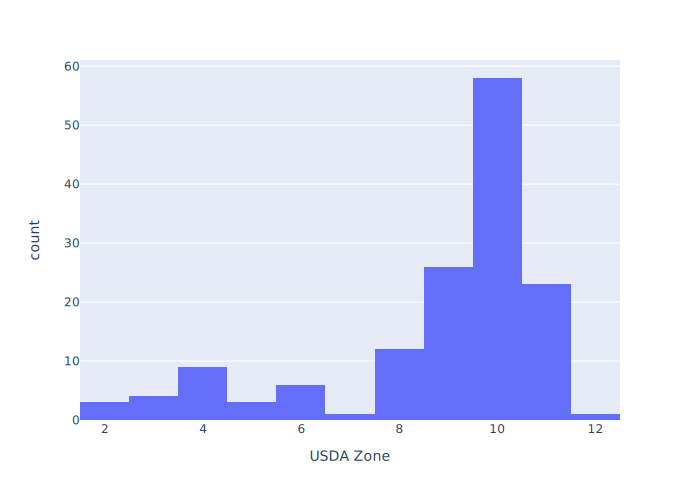

In [27]:
fig = px.histogram(x=min_zones, labels={"x": "USDA Zone"})
fig.show("svg")

- First, the plant with missing data is the "Basella alba", from a quick google it is winter hardy till USDA zone 6, so can add that in.
- Max "cold hardyness", i.e., minimum zone value can be used as a continous variable. I can also convert these values from zones to temperatures https://planthardiness.ars.usda.gov/
- Need to consider that if these are house plants, cold hardyness may not be that important to consider. 


##### Part 1.3 - Columns: "Native_Range"

In [28]:
plant_df["Native_Range"].value_counts()

None                                                26
Brazil                                               6
Madagascar                                           5
Garden origin                                        3
Mediterranean                                        3
                                                    ..
Southeast Asia, Polynesia, subtropical Australia     1
Southern and eastern Asia                            1
Tropical Africa and tropical Asia                    1
Central and western Europe                           1
China, Japan                                         1
Name: Native_Range, Length: 91, dtype: int64

Sceptical of the usefulness of this. Would need to generalise the results here a lot and even then one country or part of a continent can have very different climates in different sections. Think the more direct information from columns like: "Sunlight", or "Zones" would be better suited. Also a lot of missing data. Very probably will not use this column as feature. 

##### Part 1.4 - Columns: "Heights" and "Spreads"

In [29]:
missing_index = plant_df["Heights"].loc[lambda x: x=="None"].index
display(plant_df.iloc[missing_index])

,Plant_Name,Plant_Type,Family,Zones,Native_Range,Heights,Spreads,Bloom_Times,Bloom_Description,Sunlight,Watering,Maintenance,Flowers,Leafs,Fruits


In [30]:
min_heights, max_heights = [], []
avg_heights, height_ranges = [], []

for description in list(plant_df["Heights"]):
    min_h = float(description.split(" ")[0])
    max_h = float(description.split(" ")[2])

    min_heights.append(min_h)
    max_heights.append(max_h)
    avg_heights.append( (min_h + max_h) /2)
    height_ranges.append( max_h - min_h)

In [31]:
fig = make_subplots(rows=2, cols=2)

fig.add_trace(go.Histogram(x=min_heights, name="Min Height"),row=1, col=1)
fig.add_trace(go.Histogram(x=max_heights, name="Max Height"),row=1, col=2)
fig.add_trace(go.Histogram(x=avg_heights, name="Avg. Height"),row=2, col=1)
fig.add_trace(go.Histogram(x=height_ranges, name="Height Range"),row=2, col=2)

fig.update_layout(title_text="Heights Column") 
fig.show("svg")

In [32]:
# identify the most extreme outliers in the heights data... 
missing_index = plant_df["Heights"].loc[lambda x: x=="50.00 to 100.00 feet"].index
display(plant_df.iloc[missing_index])

missing_index = plant_df["Heights"].loc[lambda x: x=="100.00 to 200.00 feet"].index
display(plant_df.iloc[missing_index])

,Plant_Name,Plant_Type,Family,Zones,Native_Range,Heights,Spreads,Bloom_Times,Bloom_Description,Sunlight,Watering,Maintenance,Flowers,Leafs,Fruits
3,Ficus elastica,Broadleaf evergreen,Moraceae,10 to 12,Southeastern Asia,50.00 to 100.00 feet,50.00 to 100.00 feet,Rarely flowers indoors,None,Part shade,Medium,Low,Insignificant,Evergreen,None


,Plant_Name,Plant_Type,Family,Zones,Native_Range,Heights,Spreads,Bloom_Times,Bloom_Description,Sunlight,Watering,Maintenance,Flowers,Leafs,Fruits
19,Araucaria heterophylla,Needled evergreen,Araucariaceae,9 to 10,Norfolk Island,100.00 to 200.00 feet,20.00 to 25.00 feet,Non-flowering,None,Part shade,Medium,Low,None,Evergreen,None


In [33]:
# Now onto spreads
min_spreads, max_spreads = [], []
avg_spreads, spread_ranges = [], []

for description in list(plant_df["Spreads"]):
    min_s = float(description.split(" ")[0])
    max_s = float(description.split(" ")[2])

    min_spreads.append(min_s)
    max_spreads.append(max_s)
    avg_spreads.append( (min_s + max_s) /2)
    spread_ranges.append( max_s - min_s)

In [34]:
fig = make_subplots(rows=2, cols=2)

fig.add_trace(go.Histogram(x=min_spreads, name="Min Spread"),row=1, col=1)
fig.add_trace(go.Histogram(x=max_spreads, name="Max Spread"),row=1, col=2)
fig.add_trace(go.Histogram(x=avg_spreads, name="Avg. Spread"),row=2, col=1)
fig.add_trace(go.Histogram(x=spread_ranges, name="Spread Range"),row=2, col=2)

fig.update_layout(title_text="Spreads Column") 
fig.show("svg")

In [35]:
# relationship between height and spread.
min_spearman =  round(stats.spearmanr(min_heights, min_spreads).correlation, 2)
min_rsquared = round(stats.linregress(max_heights, max_spreads).rvalue**2, 2)

max_spearman =  round(stats.spearmanr(max_heights, max_spreads).correlation, 2)
max_rsquared = round(stats.linregress(max_heights, max_spreads).rvalue**2, 2)

min_title = f"rsquared: {min_rsquared}. Spearman's Rank: {min_spearman}"
max_title = f"rsquared: {max_rsquared}. Spearman's Rank: {max_spearman}"

fig = make_subplots(rows=1, cols=2,
    subplot_titles=(min_title, max_title)
)

fig.add_trace(go.Scatter(x=min_heights, y=min_spreads, name="Mins", mode='markers'),row=1, col=1)
fig.add_trace(go.Scatter(x=max_heights, y=max_spreads, name="Maxs", mode='markers'),row=1, col=2)

fig.update_layout(title_text="Heigths vs Spreads, All Data") 
fig.show("svg")

In [36]:
def clean_heights_spreads(list_values:list) -> list:
    """
    Quick helper function to set max possible height or spread value to 20 feet (approx 6 meters).
    """
    cleaned_values = []
    for value in list_values:
        if value > 20:
            value = 20
        cleaned_values.append(value)
    return cleaned_values

clean_max_heights = clean_heights_spreads(max_heights)
clean_max_spreads = clean_heights_spreads(max_spreads)

# relationship between height and spread.
max_spearman =  round(stats.spearmanr(clean_max_heights, clean_max_spreads).correlation, 2)
max_rsquared = round(stats.linregress(clean_max_heights, clean_max_spreads).rvalue**2, 2)

max_title = f"rsquared: {max_rsquared}. Spearman's Rank: {max_spearman}"

fig = go.Figure(data=go.Scatter(x=clean_max_heights, y=clean_max_spreads, mode="markers"))
fig.update_layout(title_text=max_title) 
fig.show("svg")

In [37]:
# Identify the plants in the above plot with large heights relative to spreads.
match_me = list(filter(lambda x: "20.00" in x, plant_df["Heights"]))
plant_df.loc[plant_df["Heights"].isin(match_me)]

,Plant_Name,Plant_Type,Family,Zones,Native_Range,Heights,Spreads,Bloom_Times,Bloom_Description,Sunlight,Watering,Maintenance,Flowers,Leafs,Fruits
13,Epipremnum aureum,Vine,Araceae,10 to 12,None,10.00 to 20.00 feet,1.00 to 2.00 feet,Rarely flowers,Flowers rarely produced,Part shade,Medium,Low,None,"Colorful, Evergreen",None
14,Hedera helix,Vine,Araliaceae,4 to 9,"Europe, Scandinavia, Russia",20.00 to 80.00 feet,3.00 to 50.00 feet,September to October,Greenish white,Part shade to full shade,Medium,Low,Insignificant,Evergreen,None
56,Euphorbia tirucalli,Tree,Euphorbiaceae,11 to 12,Tropical and southern Africa east to Indonesia,20.00 to 30.00 feet,6.00 to 10.00 feet,May to July,Yellow,Full sun,Dry to medium,Low,Insignificant,None,None
78,Punica granatum,Deciduous shrub,Lythraceae,8 to 11,Middle and western Asia,6.00 to 20.00 feet,4.00 to 15.00 feet,July to August,Orange-red,Full sun,Dry to medium,Medium,Showy,None,"Showy, Edible"
81,Pachira aquatica,Broadleaf evergreen,Malvaceae,10 to 12,"Mexico, northern South America",20.00 to 30.00 feet,20.00 to 30.00 feet,Seasonal bloomer,Yellowish-white with red-tipped stamens,Full sun to part shade,Medium to wet,Medium,"Showy, Fragrant",Evergreen,"Showy, Edible"
106,Philodendron hederaceum,Vine,Araceae,11 to 12,"Mexico, Caribbean, Central and South America",10.00 to 20.00 feet,3.00 to 6.00 feet,Rarely flowers indoors,Greenish-white,Part shade,Medium,Low,None,Evergreen,None
123,Asparagus plumosus,Vine,Asparagaceae,9 to 12,Southern and eastern Africa,10.00 to 20.00 feet,2.00 to 3.00 feet,Seasonal bloomer,White,Part shade,Medium,Low,None,Evergreen,None
124,Stephanotis floribunda,Broadleaf evergreen,Apocynaceae,12 to 12,Madagascar,12.00 to 20.00 feet,3.00 to 6.00 feet,Seasonal bloomer,White,Full sun to part shade,Medium,Medium,"Showy, Fragrant, Good Cut",Evergreen,None
131,Musa acuminata,Herbaceous perennial,Musaceae,10 to 11,"Southeast Asia, Australia, eastern Africa",12.00 to 20.00 feet,6.00 to 10.00 feet,Seasonal bloomer,Cream to yellow,Full sun,Medium,Medium,Showy,Evergreen,"Showy, Edible"
135,Dracaena marginata,Broadleaf evergreen,Asparagaceae,10 to 12,"Madagascar, Mauritius",15.00 to 20.00 feet,3.00 to 10.00 feet,Seasonal bloomer,White,Part shade,Medium,Low,"Showy, Fragrant","Colorful, Evergreen",Showy


**Heights Column:**

- Could turn this into a single column with max height or perhaps average height or perhaps height range.
Same thought process for spreads. Certainly could make 1 or more columns of continous data with this.
- Challenge here is there are some very large outliers, which could mess up the dimensionality reduction. Just because it can be this large does not mean it will be in someones home either... 
- For example, if you google image search the largest plant "Araucaria heterophylla" with the term "houseplant", you get plently of reasonably sized houseplant pics, so this is rather misleading under the context we are interested in. 
- Could set a max value around 10-20 feet and just have this represent those that can grow as big as you will let them. 
- Will also need to convert from feet to meters later.

**Spreads Column:**
- TODO


**Combined Considerations:**
- Clearly strongly correlated (as evidenced by the Spearman's rank value), with the rsquared value weakended due to some outliers at the extremes. 
- If I did as suggested above (set a max value), then the correlation between the two variables is further improved. So should really only need to use one of them. 
- The two major outliers (see dataframe above, "Epipremnum aureum" and "Hedera helix") are vine plants, which explains a much greater height to spread ratio (wrap around trees and climb up them etc..)
- In this case, it seems to me that max height would be more relevant, so I will calculate features for both heights and spreads, but only use heights in any model building steps (can use spreads for visualisation perhaps so doesn't hurt to process them now).

##### Part 1.5 - Columns: "Bloom_Times", "Bloom_Description" and "Flowers"

In [38]:
plant_df["Bloom_Times"].value_counts()

Seasonal bloomer          62
Rarely flowers indoors    14
Non-flowering             13
Flowers freely             9
Flowers not showy          7
April                      7
May to June                7
Rarely flowers             6
April to May               5
July to August             4
June to July               2
February to March          2
June to August             2
July to frost              1
August                     1
July to September          1
September to October       1
May to July                1
November to March          1
April to August            1
Name: Bloom_Times, dtype: int64

In [39]:
plant_df["Bloom_Description"].value_counts()

None                              17
White                             14
Yellow                             9
Greenish-white                     8
Green                              6
                                  ..
Maroon-dark red                    1
Soft pink                          1
rarely flowers indoors             1
Pink, red, lilac, white            1
White spadix with green spathe     1
Name: Bloom_Description, Length: 85, dtype: int64

In [40]:
plant_df["Flowers"].value_counts()

Showy                          66
Insignificant                  32
None                           22
Showy, Fragrant                16
Showy, Good Cut                 5
Showy, Fragrant, Good Cut       4
Fragrant, Insignificant         1
Showy, Good Cut, Good Dried     1
Name: Flowers, dtype: int64

In [41]:
bloom_times = list(plant_df["Bloom_Times"])

non_flowering_terms = ["Non-flowering"]
rarely_flowering_terms = ["Rarely flowers indoors", "Rarely flowers"]

flower_or_not = []
for descript in bloom_times:
    if descript in non_flowering_terms:
        flower_or_not.append("No")
    elif descript in rarely_flowering_terms:
        flower_or_not.append("Rarely")
    else:
        flower_or_not.append("Yes")

In [48]:
# Compare if the two columns agree with one another or not. 
plant_df["Flower_Or_Not"] = flower_or_not
plant_df[["Flower_Or_Not", "Bloom_Description"]].value_counts(sort=False)

Flower_Or_Not  Bloom_Description                                                   
No             Non-flowering                                                           3
               None                                                                    9
               non-flowering                                                           1
Rarely         Flowers rarely produced                                                 1
               Greenish white                                                          2
                                                                                      ..
Yes            Yellow, red, mahogany, bicolor rays with brown to purple center disk    1
               Yellow-green                                                            2
               Yellowish-green                                                         1
               Yellowish-white with red-tipped stamens                                 1
               white, pink

In [49]:
plant_df["Flower_Or_Not"].value_counts()

Yes       114
Rarely     20
No         13
Name: Flower_Or_Not, dtype: int64

In [50]:
plant_df[["Flower_Or_Not", "Flowers"]].value_counts(sort=False)

Flower_Or_Not  Flowers                    
No             None                           13
Rarely         Insignificant                   8
               None                            6
               Showy                           6
Yes            Fragrant, Insignificant         1
               Insignificant                  24
               None                            3
               Showy                          60
               Showy, Fragrant                16
               Showy, Fragrant, Good Cut       4
               Showy, Good Cut                 5
               Showy, Good Cut, Good Dried     1
dtype: int64

In [51]:
# Stated as flowering but"None" in the column "Flowers"
yes_plant_df = plant_df.iloc[ (plant_df["Flower_Or_Not"].loc[lambda x: x=="Yes"].index)]
yes_plant_df.loc[ (yes_plant_df["Flowers"].loc[lambda x: x=="None"].index )]

,Plant_Name,Plant_Type,Family,Zones,Native_Range,Heights,Spreads,Bloom_Times,Bloom_Description,Sunlight,Watering,Maintenance,Flowers,Leafs,Fruits,Flower_Or_Not
31,Anthurium crassinervium,Herbaceous perennial,Araceae,10 to 12,"Caribbean, northern South America",5.00 to 6.00 feet,4.00 to 6.00 feet,Flowers freely,"Red, Green to purple spathe and purple spadix",Full sun to part shade,Medium,Medium,None,None,Showy,Yes
85,Ludisia discolor,Orchid,Orchidaceae,11 to 12,None,0.25 to 1.50 feet,0.25 to 2.00 feet,Seasonal bloomer,White,Part shade,Medium,Medium,None,Colorful,None,Yes
123,Asparagus plumosus,Vine,Asparagaceae,9 to 12,Southern and eastern Africa,10.00 to 20.00 feet,2.00 to 3.00 feet,Seasonal bloomer,White,Part shade,Medium,Low,None,Evergreen,None,Yes


- The "Bloom_Times" column can be used to generate a new column with 3 labels ("No", "Rarely" "Yes"). For modelling can be: (0, 1, 2). 
- Comparing the "Bloom_Times" and "Bloom_Description" columns above shows the descriptions largely are consistent with one another. 
- Comparison of the "Flowers" column with the newly created "Flower_Or_Not" has three cases of "None" in the cell block above. Manual investigation (quick google image search) shows these to be flowering, so I can use my newly created "Flower_Or_Not" column wirth confidence. 

##### Part 1.6 - Columns: "Sunlight", "Watering", and "Maintenance"

In [52]:
plant_df["Sunlight"].value_counts()

Part shade                  55
Full sun to part shade      36
Part shade to full shade    28
Full sun                    27
None                         1
Name: Sunlight, dtype: int64

In [53]:
plant_df["Watering"].value_counts()

Medium           122
Dry to medium     14
Medium to wet      5
Wet                3
Dry                2
None               1
Name: Watering, dtype: int64

In [54]:
plant_df["Maintenance"].value_counts()

Low       79
Medium    55
High      12
None       1
Name: Maintenance, dtype: int64

In [55]:
# identify the plant with missing data
missing_index = plant_df["Maintenance"].loc[lambda x: x=="None"].index
plant_df.iloc[missing_index]

,Plant_Name,Plant_Type,Family,Zones,Native_Range,Heights,Spreads,Bloom_Times,Bloom_Description,Sunlight,Watering,Maintenance,Flowers,Leafs,Fruits,Flower_Or_Not
23,Asplenium antiquum,Fern,Aspleniaceae,10 to 11,None,1.50 to 2.00 feet,3.00 to 4.00 feet,Non-flowering,None,None,None,None,None,None,None,No


I want all three of these features and all three are very easy to do ordinal encoding with so no issues with many columns (unlike with one-hot encoding...)

One plant  with missing data (see cell block above). [From checking the plant database though](https://www.missouribotanicalgarden.org/PlantFinder/PlantFinderDetails.aspx?taxonid=241952), the info is available (just in paragraph form), so I can manually add this info into this column 

##### Part 1.7 - Columns: "Leafs", and "Fruits"

In [56]:
plant_df["Leafs"].value_counts() 

Evergreen              75
None                   31
Colorful, Evergreen    21
Colorful               16
Fragrant, Evergreen     2
Good Fall               1
Fragrant                1
Name: Leafs, dtype: int64

In [57]:
missing_index = plant_df["Leafs"].loc[lambda x: x=="None"].index
plant_df.iloc[missing_index].head(5)

,Plant_Name,Plant_Type,Family,Zones,Native_Range,Heights,Spreads,Bloom_Times,Bloom_Description,Sunlight,Watering,Maintenance,Flowers,Leafs,Fruits,Flower_Or_Not
4,Woodsia obtusa,Fern,Woodsiaceae,4 to 8,North America,1.00 to 1.50 feet,2.00 to 2.50 feet,Non-flowering,Non-flowering,Part shade to full shade,Medium,Medium,None,None,None,No
8,Capsicum annuum,Herbaceous perennial,Solanaceae,9 to 11,"Guatemala, Mexico",1.00 to 4.00 feet,1.00 to 2.00 feet,Flowers not showy,"White, yellow",Full sun,Medium,Low,Insignificant,None,"Showy, Edible",Yes
12,Zantedeschia,Herbaceous perennial,Araceae,8 to 10,Southern Africa,2.00 to 3.00 feet,1.50 to 2.00 feet,June to July,White spathe with yellow spadix,Full sun to part shade,Medium to wet,Medium,"Showy, Good Cut",None,None,Yes
23,Asplenium antiquum,Fern,Aspleniaceae,10 to 11,None,1.50 to 2.00 feet,3.00 to 4.00 feet,Non-flowering,None,None,None,None,None,None,None,No
26,Helianthus annuus,Annual,Asteraceae,2 to 11,United States and Central America,3.00 to 10.00 feet,1.50 to 3.00 feet,July to August,"Yellow, red, mahogany, bicolor rays with brown...",Full sun,Dry to medium,Low,Showy,None,None,Yes


In [58]:
plant_df["Fruits"].value_counts() 

None             113
Showy             24
Showy, Edible     10
Name: Fruits, dtype: int64

- For "Leaves" - Could be binary: "colorful" or "not_colorful". I inspected the first 5 with "None" in google images. All had green leaves so happy to default them to "not_colorful". 
- For "Fruits" - Same as above, binary fruits or not.